In [1]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import optuna
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('parkinsons.csv')
X = df.drop(['name', 'status'], axis=1)
y = df['status']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split and balance dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Evaluation helper
def print_metrics(y_true, y_pred, y_proba=None):
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
    if y_proba is not None:
        try:
            print(f"ROC AUC:   {roc_auc_score(y_true, y_proba[:, 1]):.4f}")
        except:
            pass
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# Model tuning with Optuna
def tune_model(name, objective_func, n_trials=20):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_func, n_trials=n_trials)
    print(f"\n{name} Best Params: {study.best_params}")
    return study.best_params

# Objective functions
def objective_xgb(trial):
    model = XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 300),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )
    model.fit(X_train_resampled, y_train_resampled)
    return accuracy_score(y_test, model.predict(X_test))

def objective_lgb(trial):
    model = LGBMClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 300),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        num_leaves=trial.suggest_int('num_leaves', 20, 60),
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_resampled, y_train_resampled)
    return accuracy_score(y_test, model.predict(X_test))

def objective_rf(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 300),
        max_depth=trial.suggest_int('max_depth', 5, 20),
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_resampled, y_train_resampled)
    return accuracy_score(y_test, model.predict(X_test))

def objective_gb(trial):
    model = GradientBoostingClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 300),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        random_state=42
    )
    model.fit(X_train_resampled, y_train_resampled)
    return accuracy_score(y_test, model.predict(X_test))

def objective_svm(trial):
    model = SVC(
        C=trial.suggest_float('C', 0.1, 10.0),
        gamma='scale',
        kernel='rbf',
        probability=True,
        random_state=42
    )
    model.fit(X_train_resampled, y_train_resampled)
    return accuracy_score(y_test, model.predict(X_test))

def objective_mlp(trial):
    model = MLPClassifier(
        hidden_layer_sizes=trial.suggest_categorical('hidden_layer_sizes', [(100,), (50,50)]),
        activation=trial.suggest_categorical('activation', ['relu', 'tanh']),
        alpha=trial.suggest_float('alpha', 1e-5, 1e-2, log=True),
        max_iter=1000,
        random_state=42
    )
    model.fit(X_train_resampled, y_train_resampled)
    return accuracy_score(y_test, model.predict(X_test))

# Optimize all models
params = {}
params['XGBoost'] = tune_model('XGBoost', objective_xgb)
params['LightGBM'] = tune_model('LightGBM', objective_lgb)
params['Random Forest'] = tune_model('Random Forest', objective_rf)
params['Gradient Boosting'] = tune_model('Gradient Boosting', objective_gb)
params['SVM'] = tune_model('SVM', objective_svm)
params['Neural Network'] = tune_model('Neural Network', objective_mlp)

# Build best models
models = {
    'XGBoost': XGBClassifier(**params['XGBoost'], random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(**params['LightGBM'], random_state=42),
    'Random Forest': RandomForestClassifier(**params['Random Forest'], random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(**params['Gradient Boosting'], random_state=42),
    'SVM': SVC(**params['SVM'], probability=True, random_state=42),
    'Neural Network': MLPClassifier(**params['Neural Network'], max_iter=1000, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{name} Test Set Metrics:")
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    print_metrics(y_test, y_pred, y_proba)

# Stacking
print("\n=== Training Stacking Ensemble ===")
stacking_clf = StackingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train_resampled, y_train_resampled)
y_pred_stack = stacking_clf.predict(X_test)
y_proba_stack = stacking_clf.predict_proba(X_test)
print("\n=== Stacking Ensemble Model Metrics ===")
print_metrics(y_test, y_pred_stack, y_proba_stack)


[I 2025-09-14 10:40:08,889] A new study created in memory with name: no-name-cd969874-68a7-4f6d-acf5-9ab70ded8835
[I 2025-09-14 10:40:09,195] Trial 0 finished with value: 0.8717948717948718 and parameters: {'n_estimators': 238, 'max_depth': 7, 'learning_rate': 0.028868928234327303}. Best is trial 0 with value: 0.8717948717948718.
[I 2025-09-14 10:40:09,307] Trial 1 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 214, 'max_depth': 4, 'learning_rate': 0.22579608725746708}. Best is trial 1 with value: 0.9487179487179487.
[I 2025-09-14 10:40:09,495] Trial 2 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 276, 'max_depth': 8, 'learning_rate': 0.08389677966638019}. Best is trial 1 with value: 0.9487179487179487.
[I 2025-09-14 10:40:09,593] Trial 3 finished with value: 0.8974358974358975 and parameters: {'n_estimators': 153, 'max_depth': 5, 'learning_rate': 0.20274361469175076}. Best is trial 1 with value: 0.9487179487179487.
[I 2025-09-14 10:


XGBoost Best Params: {'n_estimators': 214, 'max_depth': 4, 'learning_rate': 0.22579608725746708}
[LightGBM] [Info] Number of positive: 118, number of negative: 118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[I 2025-09-14 10:40:13,025] Trial 1 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 169, 'learning_rate': 0.07126283639142489, 'num_leaves': 21}. Best is trial 0 with value: 0.9487179487179487.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-14 10:40:13,237] Trial 2 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 178, 'learning_rate': 0.0807370624925629, 'num_leaves': 37}. Best is trial 0 with value: 0.9487179487179487.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-14 10:40:13,421] Trial 3 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 230, 'learning_rate': 0.20981603360161624, 'num_leaves': 40}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:13,624] Trial 4 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 159, 'learning_rate': 0.051338017928562026, 'num_leaves': 50}. Best is trial 0 with value: 0.9487179487179487.


[LightGBM] [Info] Number of positive: 118, number of negative: 118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-09-14 10:40:13,831] Trial 5 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 148, 'learning_rate': 0.120457097587295, 'num_leaves': 38}. Best is trial 0 with value: 0.9487179487179487.


[LightGBM] [Info] Number of positive: 118, number of negative: 118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-09-14 10:40:13,897] Trial 6 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 189, 'learning_rate': 0.12977126077434567, 'num_leaves': 21}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:13,940] Trial 7 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 168, 'learning_rate': 0.28541970854909543, 'num_leaves': 48}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:13,988] Trial 8 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 287, 'learning_rate': 0.2927122964488457, 'num_leaves': 26}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:14,038] Trial 9 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 258, 'learning_rate': 0.21736562878145055, 'num_leaves': 22}. Best is trial 0 with value: 0.9487179487179487.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-14 10:40:14,106] Trial 10 finished with value: 0.8205128205128205 and parameters: {'n_estimators': 108, 'learning_rate': 0.012074560049539468, 'num_leaves': 60}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:14,191] Trial 11 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 231, 'learning_rate': 0.19540293054852864, 'num_leaves': 46}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:14,253] Trial 12 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 226, 'learning_rate': 0.20381356905573542, 'num_leaves': 35}. Best is trial 0 with value: 0.9487179487179487.


[LightGBM] [Info] Number of positive: 118, number of negative: 118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-09-14 10:40:14,331] Trial 13 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 126, 'learning_rate': 0.15771112799921616, 'num_leaves': 31}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:14,392] Trial 14 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 220, 'learning_rate': 0.23746758520415906, 'num_leaves': 42}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:14,467] Trial 15 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 259, 'learning_rate': 0.16314541921579478, 'num_leaves': 54}. Best is trial 0 with value: 0.9487179487179487.


[LightGBM] [Info] Number of positive: 118, number of negative: 118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-09-14 10:40:14,535] Trial 16 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 212, 'learning_rate': 0.25790050822767974, 'num_leaves': 43}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:14,585] Trial 17 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 103, 'learning_rate': 0.11981328423072181, 'num_leaves': 32}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:14,643] Trial 18 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 139, 'learning_rate': 0.18543101249125304, 'num_leaves': 51}. Best is trial 0 with value: 0.9487179487179487.


[LightGBM] [Info] Number of positive: 118, number of negative: 118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-09-14 10:40:14,741] Trial 19 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 248, 'learning_rate': 0.10378043733454648, 'num_leaves': 44}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:14,747] A new study created in memory with name: no-name-d4841603-99ea-45f4-904e-b112a4ce7931


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-14 10:40:15,349] Trial 0 finished with value: 0.8974358974358975 and parameters: {'n_estimators': 251, 'max_depth': 17}. Best is trial 0 with value: 0.8974358974358975.
[I 2025-09-14 10:40:15,776] Trial 1 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 171, 'max_depth': 15}. Best is trial 1 with value: 0.9487179487179487.
[I 2025-09-14 10:40:16,369] Trial 2 finished with value: 0.8205128205128205 and parameters: {'n_estimators': 248, 'max_depth': 5}. Best is trial 1 with value: 0.9487179487179487.
[I 2025-09-14 10:40:16,834] Trial 3 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 195, 'max_depth': 8}. Best is trial 1 with value: 0.9487179487179487.
[I 2025-09-14 10:40:17,135] Trial 4 finished with value: 0.7948717948717948 and parameters: {'n_estimators': 118, 'max_depth': 5}. Best is trial 1 with value: 0.9487179487179487.
[I 2025-09-14 10:40:17,543] Trial 5 finished with value: 0.9487179487179487 and parameters: {'n_estimat


Random Forest Best Params: {'n_estimators': 171, 'max_depth': 15}


[I 2025-09-14 10:40:24,194] Trial 0 finished with value: 0.8205128205128205 and parameters: {'n_estimators': 188, 'learning_rate': 0.2351866809008559, 'max_depth': 9}. Best is trial 0 with value: 0.8205128205128205.
[I 2025-09-14 10:40:24,815] Trial 1 finished with value: 0.8205128205128205 and parameters: {'n_estimators': 286, 'learning_rate': 0.2897679060493381, 'max_depth': 8}. Best is trial 0 with value: 0.8205128205128205.
[I 2025-09-14 10:40:25,707] Trial 2 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 188, 'learning_rate': 0.1516670370837536, 'max_depth': 3}. Best is trial 2 with value: 0.9487179487179487.
[I 2025-09-14 10:40:26,383] Trial 3 finished with value: 0.8461538461538461 and parameters: {'n_estimators': 180, 'learning_rate': 0.2129240570209648, 'max_depth': 5}. Best is trial 2 with value: 0.9487179487179487.
[I 2025-09-14 10:40:27,003] Trial 4 finished with value: 0.9487179487179487 and parameters: {'n_estimators': 168, 'learning_rate': 0.200


Gradient Boosting Best Params: {'n_estimators': 153, 'learning_rate': 0.2703911241409446, 'max_depth': 3}


[I 2025-09-14 10:40:36,848] Trial 9 finished with value: 0.8974358974358975 and parameters: {'C': 7.7716610764044685}. Best is trial 1 with value: 0.8974358974358975.
[I 2025-09-14 10:40:36,877] Trial 10 finished with value: 0.8974358974358975 and parameters: {'C': 9.084140759704013}. Best is trial 1 with value: 0.8974358974358975.
[I 2025-09-14 10:40:36,905] Trial 11 finished with value: 0.8974358974358975 and parameters: {'C': 7.482172590563421}. Best is trial 1 with value: 0.8974358974358975.
[I 2025-09-14 10:40:36,927] Trial 12 finished with value: 0.8717948717948718 and parameters: {'C': 6.984982618786258}. Best is trial 1 with value: 0.8974358974358975.
[I 2025-09-14 10:40:36,960] Trial 13 finished with value: 0.8717948717948718 and parameters: {'C': 9.897909290511222}. Best is trial 1 with value: 0.8974358974358975.
[I 2025-09-14 10:40:36,993] Trial 14 finished with value: 0.8717948717948718 and parameters: {'C': 6.51185202942507}. Best is trial 1 with value: 0.8974358974358975.


SVM Best Params: {'C': 8.009539247504033}


[I 2025-09-14 10:40:39,316] Trial 0 finished with value: 0.9487179487179487 and parameters: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'alpha': 0.0038265802290550076}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:41,832] Trial 1 finished with value: 0.9487179487179487 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'alpha': 0.0004748922899736801}. Best is trial 0 with value: 0.9487179487179487.
[I 2025-09-14 10:40:42,424] Trial 2 finished with value: 0.9743589743589743 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'alpha': 8.583286830428251e-05}. Best is trial 2 with value: 0.9743589743589743.
[I 2025-09-14 10:40:42,977] Trial 3 finished with value: 0.9743589743589743 and parameters: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'alpha': 1.9855781437798034e-05}. Best is trial 2 with value: 0.9743589743589743.
[I 2025-09-14 10:40:44,940] Trial 4 finished with value: 0.9487179487179487 and parameters: {


Neural Network Best Params: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'alpha': 8.583286830428251e-05}

XGBoost Test Set Metrics:
Accuracy:  0.9487
Precision: 0.9655
Recall:    0.9655
F1 Score:  0.9655
ROC AUC:   0.9759

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.97      0.97      0.97        29

    accuracy                           0.95        39
   macro avg       0.93      0.93      0.93        39
weighted avg       0.95      0.95      0.95        39

Confusion Matrix:
[[ 9  1]
 [ 1 28]]

LightGBM Test Set Metrics:
[LightGBM] [Info] Number of positive: 118, number of negative: 118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 236, number of used features: 22

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# For Stacking
fpr, tpr, _ = roc_curve(y_test, y_proba_stack[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Stacking (AUC = {roc_auc:.2f})', linestyle='--', linewidth=2, color='black')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


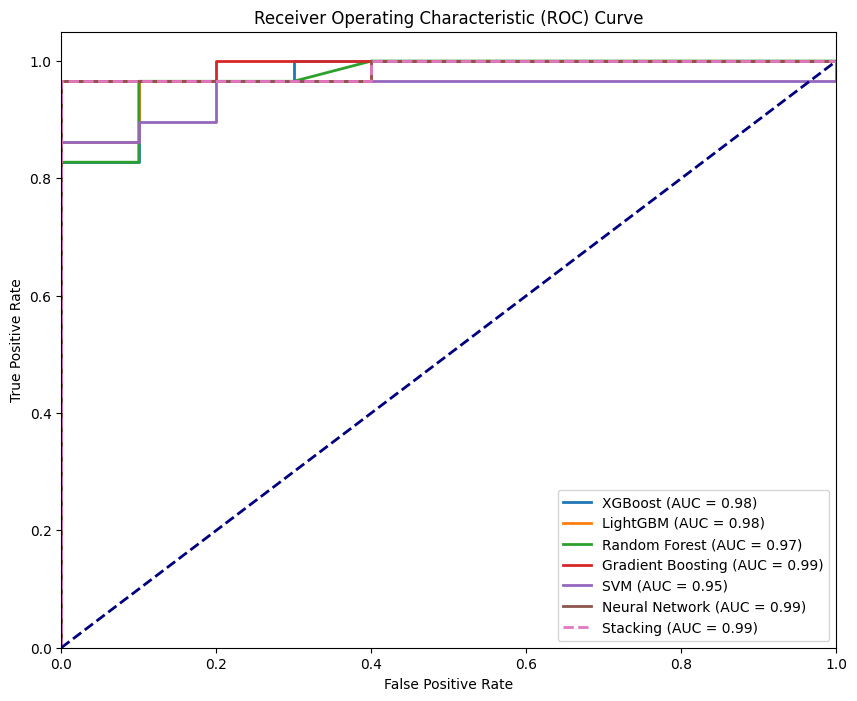

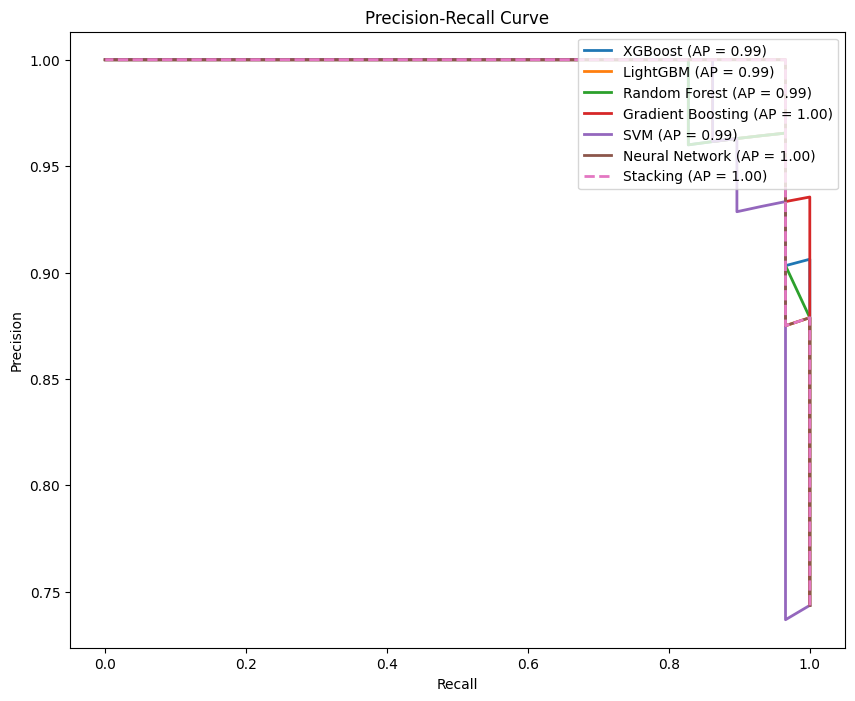

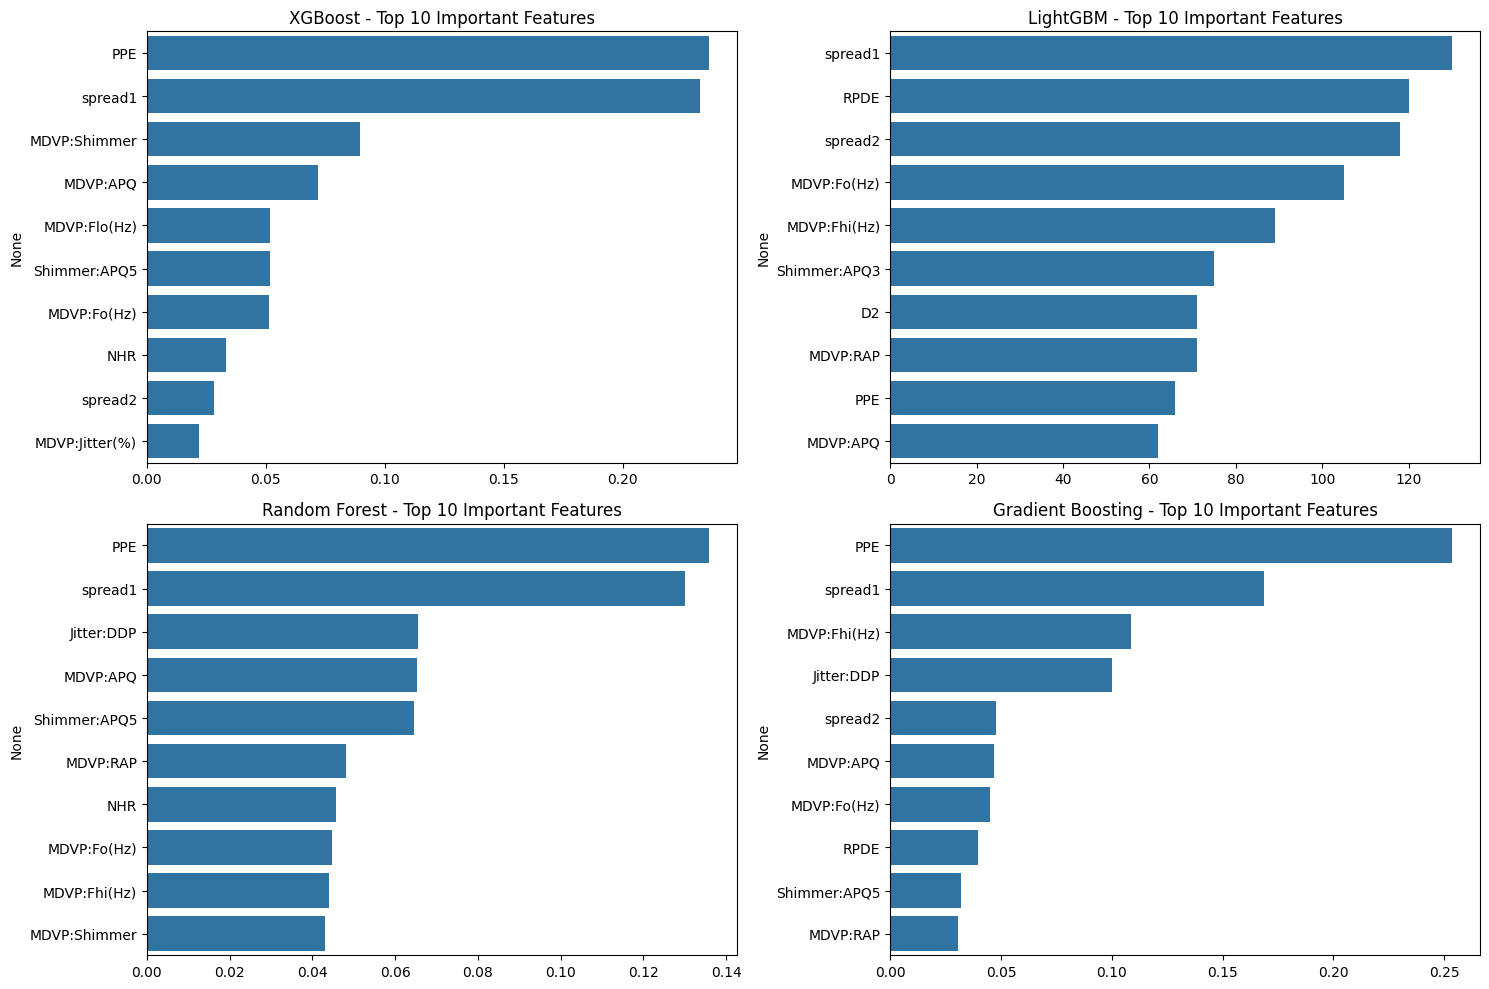

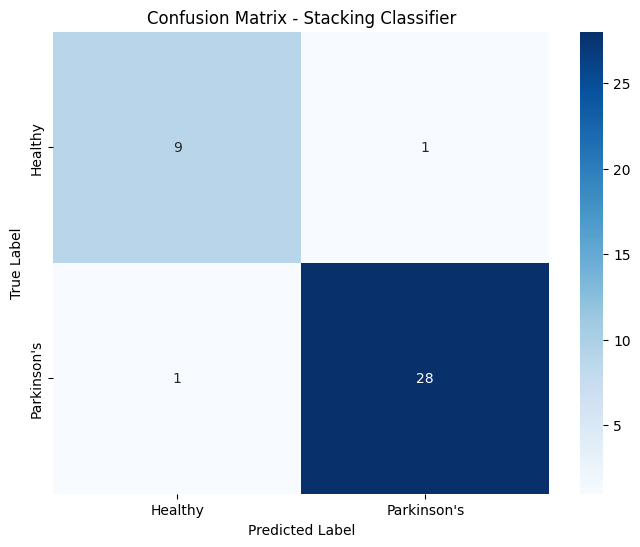

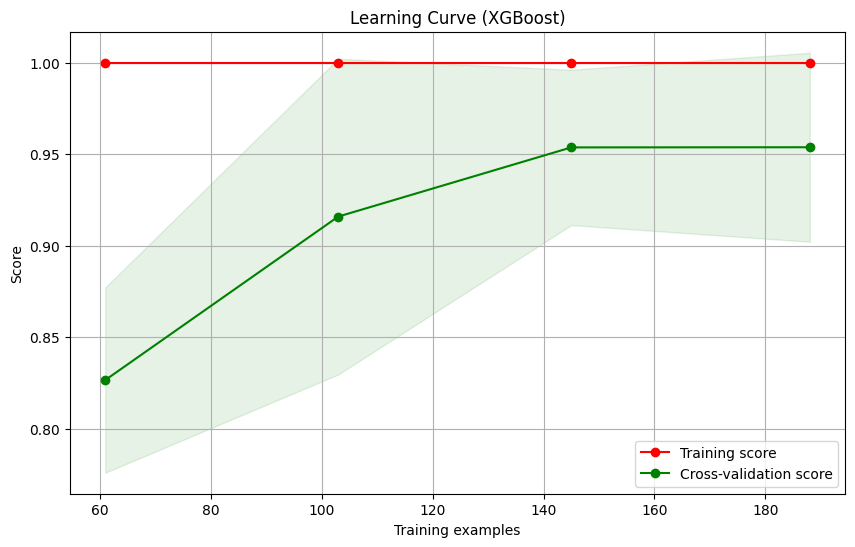

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve



# 1. ROC Curve for all models
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Add stacking classifier
y_proba_stack = stacking_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_stack)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, linestyle='--', label=f'Stacking (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 2. Precision-Recall Curve
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        avg_precision = average_precision_score(y_test, y_proba)
        plt.plot(recall, precision, lw=2, label=f'{name} (AP = {avg_precision:.2f})')

# Add stacking classifier
precision, recall, _ = precision_recall_curve(y_test, y_proba_stack)
avg_precision = average_precision_score(y_test, y_proba_stack)
plt.plot(recall, precision, lw=2, linestyle='--', label=f'Stacking (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

# 3. Feature Importance (for tree-based models)
tree_based_models = {
    'XGBoost': models['XGBoost'],
    'LightGBM': models['LightGBM'],
    'Random Forest': models['Random Forest'],
    'Gradient Boosting': models['Gradient Boosting']
}

plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(tree_based_models.items(), 1):
    plt.subplot(2, 2, i)

    if name == 'XGBoost':
        importances = model.feature_importances_
    elif name == 'LightGBM':
        importances = model.feature_importances_
    else:
        importances = model.feature_importances_

    indices = np.argsort(importances)[::-1]
    features = X.columns[indices]

    sns.barplot(x=importances[indices][:10], y=features[:10])
    plt.title(f'{name} - Top 10 Important Features')
    plt.tight_layout()

plt.show()

# 4. Confusion Matrix Heatmap for Stacking Classifier
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_stack)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Parkinson\'s'],
            yticklabels=['Healthy', 'Parkinson\'s'])
plt.title('Confusion Matrix - Stacking Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. Learning Curves (Optional - takes more time)
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Example for one model (you can add more)
plot_learning_curve(models['XGBoost'], "Learning Curve (XGBoost)", X_train_resampled, y_train_resampled, cv=5)
plt.show()

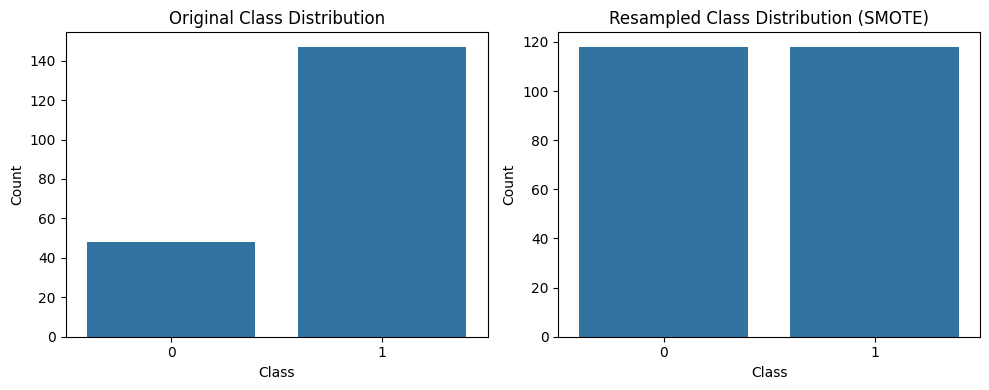

In [6]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=y, ax=ax[0])
ax[0].set_title('Original Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

sns.countplot(x=y_train_resampled, ax=ax[1])
ax[1].set_title('Resampled Class Distribution (SMOTE)')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()
